In [53]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.optim as optim
from torch.autograd import Variable
import numpy.random as rand
import numpy as np
import sys
import os
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from sklearn.metrics import fbeta_score
from scipy.stats import norm
from matplotlib import gridspec
from graph_utils import calibrationPlot


from bnn import BNNBayesbyBackprop, gauss_logpdf
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/d_berman/Documents/Tufts_Masters/Semester_3/Bayesian Deep Learning/BDL_final_project'

/anaconda3/envs/Pytorch/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/anaconda3/envs/Pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


sklearn logistic regression accuracy is: 0.8842


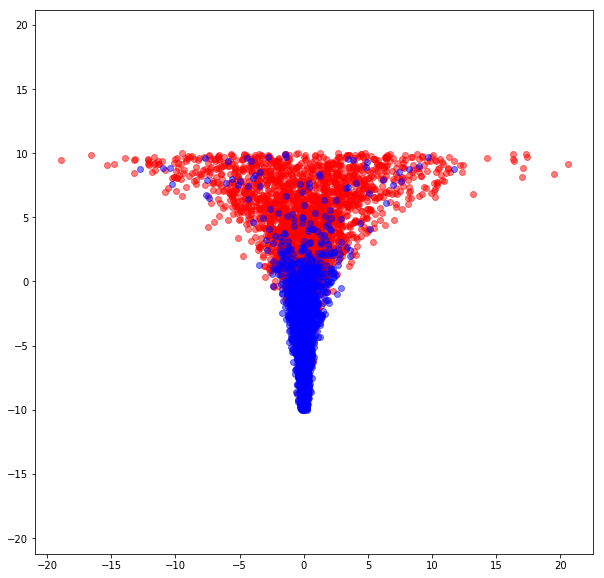

In [45]:
dataset_size = 5000

X_train = np.empty(shape=(dataset_size, 2), dtype=float)
y_train = np.empty(shape=(dataset_size,), dtype=float)

X_train[:, 0] = 0
X_train[:, 1] = np.random.uniform(-10, 10, 
                                  size=(int(dataset_size),))

for i, row_i in enumerate(X_train):
    # want b2=0 and w2_1=0.08
    X_train[i, 0] = np.random.normal(loc=0, scale=np.exp(0.2 * X_train[i, 1]))
    
dec_boundry = X_train[:, 0] * 0 + np.random.normal(0, 1.8, size=(X_train[:,0].shape))
y_train[X_train[:,1] >= dec_boundry] = 0
y_train[X_train[:,1] < dec_boundry] = 1

# add a bit of uniform noise by randomly flipping 5% of the labels
perm = np.random.permutation(y_train.shape[0])
y_train[perm[:int(0.05 * dataset_size)]] = (~y_train[perm[:int(0.05 * dataset_size)]].astype(bool)).astype(int)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='red', alpha=0.5)
ax.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='blue', alpha=0.5)
ax.axis('equal')
fig.show()
y_train

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('sklearn logistic regression accuracy is:', lr.score(X_train, y_train))

Data being saved in following file:
logging.csv
Epoch:  0 	Loss:  6985.209 	acc:  0.1672
Epoch:  1 	Loss:  6821.627 	acc:  0.6634
Epoch:  2 	Loss:  6653.5327 	acc:  0.8104
Epoch:  3 	Loss:  6588.3716 	acc:  0.7552
Epoch:  4 	Loss:  5719.5815 	acc:  0.8812
Epoch:  5 	Loss:  5779.3306 	acc:  0.3494
Epoch:  6 	Loss:  5342.7466 	acc:  0.1326
Epoch:  7 	Loss:  5108.0063 	acc:  0.8524
Epoch:  8 	Loss:  4809.4526 	acc:  0.241
Epoch:  9 	Loss:  4686.6006 	acc:  0.6658
Epoch:  10 	Loss:  4161.0205 	acc:  0.8824
Epoch:  11 	Loss:  4262.023 	acc:  0.8706
Epoch:  12 	Loss:  4051.4785 	acc:  0.862
Epoch:  13 	Loss:  4184.492 	acc:  0.6684
Epoch:  14 	Loss:  3969.975 	acc:  0.4634
Epoch:  15 	Loss:  3901.5981 	acc:  0.8592
Epoch:  16 	Loss:  3679.4873 	acc:  0.8674
Epoch:  17 	Loss:  3570.3003 	acc:  0.8792
Epoch:  18 	Loss:  3419.4014 	acc:  0.833
Epoch:  19 	Loss:  3385.838 	acc:  0.122
Epoch:  20 	Loss:  3304.7036 	acc:  0.2276
Epoch:  21 	Loss:  3023.4746 	acc:  0.8846
Epoch:  22 	Loss:  3150.48

Epoch:  190 	Loss:  1738.7583 	acc:  0.8842
Epoch:  191 	Loss:  1729.9521 	acc:  0.8792
Epoch:  192 	Loss:  1743.6562 	acc:  0.817
Epoch:  193 	Loss:  1734.9583 	acc:  0.8828
Epoch:  194 	Loss:  1727.8582 	acc:  0.883
Epoch:  195 	Loss:  1740.1091 	acc:  0.8814
Epoch:  196 	Loss:  1731.0273 	acc:  0.8804
Epoch:  197 	Loss:  1726.5732 	acc:  0.8658
Epoch:  198 	Loss:  1726.3297 	acc:  0.884
Epoch:  199 	Loss:  1718.1791 	acc:  0.882
Epoch:  200 	Loss:  1718.4207 	acc:  0.8798
Epoch:  201 	Loss:  1722.9451 	acc:  0.8838
Epoch:  202 	Loss:  1722.7494 	acc:  0.8826
Epoch:  203 	Loss:  1726.5967 	acc:  0.8802
Epoch:  204 	Loss:  1722.6133 	acc:  0.884
Epoch:  205 	Loss:  1720.6046 	acc:  0.8834
Epoch:  206 	Loss:  1724.4373 	acc:  0.8796
Epoch:  207 	Loss:  1720.0446 	acc:  0.8774
Epoch:  208 	Loss:  1714.9026 	acc:  0.8824
Epoch:  209 	Loss:  1724.8181 	acc:  0.8818
Epoch:  210 	Loss:  1720.008 	acc:  0.8816
Epoch:  211 	Loss:  1721.9346 	acc:  0.8836
Epoch:  212 	Loss:  1720.753 	acc:  0.

Epoch:  378 	Loss:  1649.1741 	acc:  0.8824
Epoch:  379 	Loss:  1647.4753 	acc:  0.883
Epoch:  380 	Loss:  1644.2288 	acc:  0.882
Epoch:  381 	Loss:  1647.0266 	acc:  0.8834
Epoch:  382 	Loss:  1647.3551 	acc:  0.8832
Epoch:  383 	Loss:  1650.9944 	acc:  0.8828
Epoch:  384 	Loss:  1647.018 	acc:  0.8846
Epoch:  385 	Loss:  1646.4324 	acc:  0.8838
Epoch:  386 	Loss:  1648.6935 	acc:  0.8838
Epoch:  387 	Loss:  1645.9386 	acc:  0.8842
Epoch:  388 	Loss:  1647.1562 	acc:  0.8842
Epoch:  389 	Loss:  1644.5142 	acc:  0.8834
Epoch:  390 	Loss:  1647.8958 	acc:  0.8842
Epoch:  391 	Loss:  1645.2168 	acc:  0.8824
Epoch:  392 	Loss:  1645.376 	acc:  0.8824
Epoch:  393 	Loss:  1643.1382 	acc:  0.8842
Epoch:  394 	Loss:  1643.771 	acc:  0.8822
Epoch:  395 	Loss:  1644.2125 	acc:  0.8836
Epoch:  396 	Loss:  1643.5017 	acc:  0.883
Epoch:  397 	Loss:  1644.076 	acc:  0.8848
Epoch:  398 	Loss:  1644.866 	acc:  0.8836
Epoch:  399 	Loss:  1645.6123 	acc:  0.8852
Epoch:  400 	Loss:  1647.0502 	acc:  0.8

Epoch:  566 	Loss:  1622.033 	acc:  0.8824
Epoch:  567 	Loss:  1623.9332 	acc:  0.884
Epoch:  568 	Loss:  1623.1298 	acc:  0.8824
Epoch:  569 	Loss:  1621.2504 	acc:  0.8842
Epoch:  570 	Loss:  1622.369 	acc:  0.8824
Epoch:  571 	Loss:  1620.6982 	acc:  0.8814
Epoch:  572 	Loss:  1621.4656 	acc:  0.884
Epoch:  573 	Loss:  1622.9841 	acc:  0.8838
Epoch:  574 	Loss:  1622.9867 	acc:  0.882
Epoch:  575 	Loss:  1620.7147 	acc:  0.8828
Epoch:  576 	Loss:  1622.0541 	acc:  0.8834
Epoch:  577 	Loss:  1621.1284 	acc:  0.8828
Epoch:  578 	Loss:  1621.0674 	acc:  0.882
Epoch:  579 	Loss:  1620.4873 	acc:  0.8838
Epoch:  580 	Loss:  1621.1973 	acc:  0.8834
Epoch:  581 	Loss:  1623.137 	acc:  0.8822
Epoch:  582 	Loss:  1621.4675 	acc:  0.8824
Epoch:  583 	Loss:  1621.7876 	acc:  0.8832
Epoch:  584 	Loss:  1620.9113 	acc:  0.8818
Epoch:  585 	Loss:  1622.846 	acc:  0.8828
Epoch:  586 	Loss:  1621.2214 	acc:  0.8818
Epoch:  587 	Loss:  1621.591 	acc:  0.8834
Epoch:  588 	Loss:  1620.9634 	acc:  0.88

Epoch:  755 	Loss:  1613.6025 	acc:  0.8824
Epoch:  756 	Loss:  1613.5042 	acc:  0.8828
Epoch:  757 	Loss:  1613.2205 	acc:  0.884
Epoch:  758 	Loss:  1612.3713 	acc:  0.883
Epoch:  759 	Loss:  1613.6863 	acc:  0.8818
Epoch:  760 	Loss:  1612.2207 	acc:  0.8838
Epoch:  761 	Loss:  1614.1348 	acc:  0.882
Epoch:  762 	Loss:  1613.6072 	acc:  0.883
Epoch:  763 	Loss:  1613.446 	acc:  0.8826
Epoch:  764 	Loss:  1613.4785 	acc:  0.8824
Epoch:  765 	Loss:  1612.0273 	acc:  0.8844
Epoch:  766 	Loss:  1613.1683 	acc:  0.8826
Epoch:  767 	Loss:  1614.5052 	acc:  0.8816
Epoch:  768 	Loss:  1613.5455 	acc:  0.8824
Epoch:  769 	Loss:  1612.5073 	acc:  0.8822
Epoch:  770 	Loss:  1612.3898 	acc:  0.8832
Epoch:  771 	Loss:  1613.5249 	acc:  0.8822
Epoch:  772 	Loss:  1612.4414 	acc:  0.8832
Epoch:  773 	Loss:  1614.1284 	acc:  0.8842
Epoch:  774 	Loss:  1612.5901 	acc:  0.8828
Epoch:  775 	Loss:  1612.9752 	acc:  0.8822
Epoch:  776 	Loss:  1612.1743 	acc:  0.8818
Epoch:  777 	Loss:  1612.2639 	acc:  

Epoch:  943 	Loss:  1609.4608 	acc:  0.8836
Epoch:  944 	Loss:  1609.2354 	acc:  0.8826
Epoch:  945 	Loss:  1609.2574 	acc:  0.8816
Epoch:  946 	Loss:  1609.4169 	acc:  0.8828
Epoch:  947 	Loss:  1610.115 	acc:  0.8816
Epoch:  948 	Loss:  1609.2568 	acc:  0.882
Epoch:  949 	Loss:  1609.6788 	acc:  0.8826
Epoch:  950 	Loss:  1609.3447 	acc:  0.882
Epoch:  951 	Loss:  1608.9124 	acc:  0.8816
Epoch:  952 	Loss:  1609.1794 	acc:  0.883
Epoch:  953 	Loss:  1608.499 	acc:  0.8822
Epoch:  954 	Loss:  1608.8114 	acc:  0.8832
Epoch:  955 	Loss:  1609.3109 	acc:  0.8832
Epoch:  956 	Loss:  1609.1333 	acc:  0.8818
Epoch:  957 	Loss:  1609.1757 	acc:  0.8824
Epoch:  958 	Loss:  1608.9272 	acc:  0.8836
Epoch:  959 	Loss:  1608.7905 	acc:  0.882
Epoch:  960 	Loss:  1608.5227 	acc:  0.8824
Epoch:  961 	Loss:  1609.4766 	acc:  0.8828
Epoch:  962 	Loss:  1609.4156 	acc:  0.8828
Epoch:  963 	Loss:  1608.1118 	acc:  0.8824
Epoch:  964 	Loss:  1609.6215 	acc:  0.8818
Epoch:  965 	Loss:  1608.8975 	acc:  0

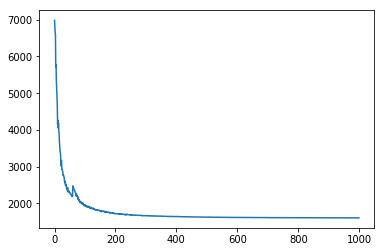

In [46]:
bnn = BNNBayesbyBackprop(input_dim=2, core_hidden_layers=[10000]*3, 
                         mu_hidden_layers=[10000]*3,
                         log_s_hidden_layers=[10000]*3,
                         prior_mu=0.0, prior_s=1.0, num_MC_samples=100, classification=True)

# bnn = BNNBayesbyBackprop(input_dim=2, core_hidden_layers=[500], mu_hidden_layers=[10],
#                          log_s_hidden_layers=[500, 500, 500, 500],
#                          prior_mu=0.0, prior_s=1.0, num_MC_samples=100, classification=True)

bnn.fit(X_train, y_train, plot=True, n_epochs=1000, learning_rate=5e-3, batch_size=1000)

unbiased sample STD between 1 and -9: 0.31213510327996397
unbiased sample STD between 1 and -8: 0.3456147314604951
unbiased sample STD between 1 and -7: 0.3702874283786308
unbiased sample STD between 1 and -6: 0.41263187134489565
unbiased sample STD between 1 and -5: 0.44288388369622894
unbiased sample STD between 1 and -4: 0.5201931828559396
unbiased sample STD between 1 and -3: 0.5880699295854602
unbiased sample STD between 1 and -2: 0.6695215707237488
unbiased sample STD between 1 and -1: 0.7894049849096416
unbiased sample STD between 1 and 0: 0.9354497144184301
unbiased sample STD between 1 and 1: 1.109846879749059
unbiased sample STD between 1 and 2: 1.3185778919397781
unbiased sample STD between 1 and 3: 1.6320537663538268
unbiased sample STD between 1 and 4: 1.9999101244215802
unbiased sample STD between 1 and 5: 2.6012714043728122
unbiased sample STD between 1 and 6: 2.8904024778475823
unbiased sample STD between 1 and 7: 3.7394253408256857
unbiased sample STD between 1 and 8: 

array([0.30217037, 0.22323717, 0.19601002, 0.15754381, 0.17255545,
       0.14670703, 0.17970365, 0.20420273, 0.402132  , 0.3337521 ,
       3.3098507 , 2.6216211 , 1.9920193 , 1.5655708 , 1.2153761 ,
       0.9537346 , 0.73666155, 0.57114786, 0.44183266, 0.34704456],
      dtype=float32)

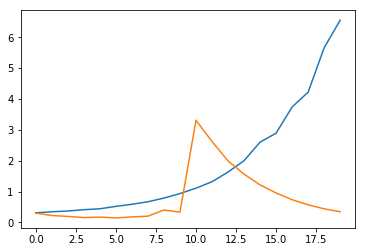

In [33]:
samples = 100
std_preds = np.empty(shape=(20,samples), dtype=np.float32)

for j in range(0,samples):
    # preds = bnn.model(X_train[X_train[:,1] <= -9])
    std_preds1 = []
    for i in range(-10, 10):
        preds = bnn.model(X_train[(X_train[:,1] >= i) & (X_train[:,1] < i + 1)])
#         print(np.mean(torch.exp(preds[:, 1]).detach().numpy().shape))
        std_preds[i,j] = np.mean(torch.exp(preds[:, 1]).detach().numpy())
        std_preds1.append(np.mean(torch.exp(preds[:, 1]).detach().numpy()))
    
emp_stds = []
for i in range(-10, 10):
    samp = X_train[(X_train[:,1] >= i) & (X_train[:,1] < i + 1)]
    mean = samp.mean(axis=0)
    samp_var = 1 / samp.shape[0] * np.sum(np.linalg.norm(samp - mean)**2 , axis=0)
    print('unbiased sample STD between {} and {}: {}'.format(1, i + 1, np.sqrt(samp_var)))
    emp_stds.append(np.sqrt(samp_var))

std_preds
plt.plot(emp_stds)
plt.plot(np.mean(std_preds, axis=1))
np.mean(std_preds, axis=1)

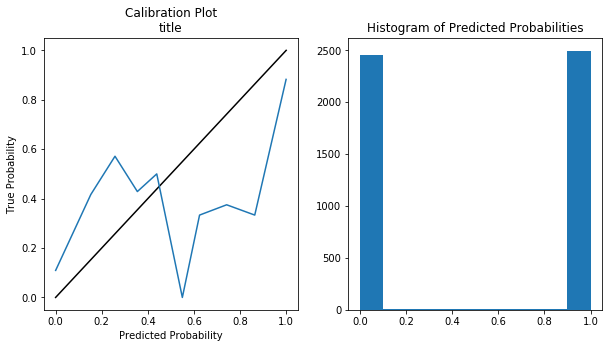

In [72]:
calibrationPlot(bnn, y_train, X_train, 'title', n_bins=10, pred_prob_hist=True)